In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Load the data
train_csv_path = '/kaggle/input/malicious-url-dataset/train_malicious_phish.csv'
val_csv_path = '/kaggle/input/malicious-url-dataset/val_malicious_phish.csv'
train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)

# Convert 'TRUE'/'FALSE' to 1/0
bool_columns = ['at_symbol_0', 'at_symbol_1', 'redirection_0', 'redirection_1',
                'has_ip_0', 'has_ip_1', 'has_https_0', 'has_https_1',
                'is_tinyurl_0', 'is_tinyurl_1']

for col in bool_columns:
    train_df[col] = train_df[col].apply(lambda x: 1 if x == 'TRUE' else 0)
    val_df[col] = val_df[col].apply(lambda x: 1 if x == 'TRUE' else 0)

# Separate features and labels
X_train = train_df.drop(columns=['type', 'url']).values
y_train = train_df['type'].values

X_val = val_df.drop(columns=['type', 'url']).values
y_val = val_df['type'].values

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/malicious-url-dataset/train_malicious_phish.csv'

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MaliciousURLCNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MaliciousURLCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5)  # Dropout layer with 50% probability
        self.fc1 = nn.Linear(64 * (input_size // 4), 100)
        self.fc2 = nn.Linear(100, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout after the first fully connected layer
        x = self.fc2(x)
        return x

input_size = X_train.shape[1]
num_classes = len(label_encoder.classes_)
model = MaliciousURLCNN(input_size, num_classes)


In [ ]:
import torch.optim as optim

# Set device
use_cuda = True
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
model.to(device)

if use_cuda and torch.cuda.is_available():
    print('CUDA is available! Training on GPU ...')
else:
    print('CUDA is not available. Training on CPU ...')

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    iters = []
    losses = []
    train_acc = []
    val_acc = []
    n_iter = 0

    for epoch in range(num_epochs):
        model.train()
        correct = 0
        total = 0
        epoch_loss = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.unsqueeze(1).to(device), labels.to(device)  # Add channel dimension

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = correct / total
        val_accuracy = get_accuracy(model, val_loader)

        # Track loss and accuracy for each epoch
        iters.append(n_iter)
        losses.append(epoch_loss / total)
        train_acc.append(train_accuracy)
        val_acc.append(val_accuracy)

        n_iter += 1

        val_accuracy = get_accuracy(model, val_loader)
        val_acc.append(val_accuracy)

        print(f'Epoch {epoch+1}, Loss: {epoch_loss/total:}, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}')

    return iters, losses, train_acc, val_acc

# Evaluation function
def get_accuracy(model, val_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.unsqueeze(1).to(device), labels.to(device)  # Add channel dimension
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

# Train the model
num_epochs = 25
iters, losses, train_acc, val_acc = train(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)


CUDA is available! Training on GPU ...
Epoch 1, Loss: 0.009429100523834305, Train Accuracy: 0.7782693991001091, Validation Accuracy: 0.8011809058730488
Epoch 2, Loss: 0.008338265236256085, Train Accuracy: 0.7980773660529185, Validation Accuracy: 0.8073541719454234
Epoch 3, Loss: 0.008118031142160028, Train Accuracy: 0.801611280885763, Validation Accuracy: 0.8091585469790155
Epoch 4, Loss: 0.008033445664416638, Train Accuracy: 0.8036863281070041, Validation Accuracy: 0.8103486666820231
Epoch 5, Loss: 0.007969554137325207, Train Accuracy: 0.805087608839202, Validation Accuracy: 0.8109552438209753
Epoch 6, Loss: 0.007933805035162486, Train Accuracy: 0.8061203335432056, Validation Accuracy: 0.8109322092460783
Epoch 7, Loss: 0.007881472770942569, Train Accuracy: 0.8070973909304504, Validation Accuracy: 0.8126905151298766
Epoch 8, Loss: 0.007837352283593816, Train Accuracy: 0.8081301156344538, Validation Accuracy: 0.8125983768302889
Epoch 9, Loss: 0.007804286042553422, Train Accuracy: 0.8089

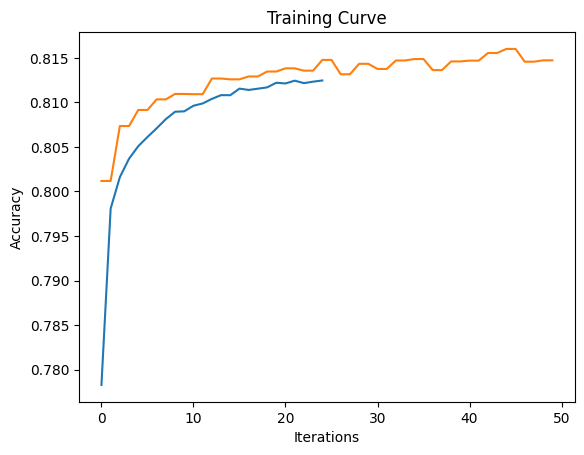

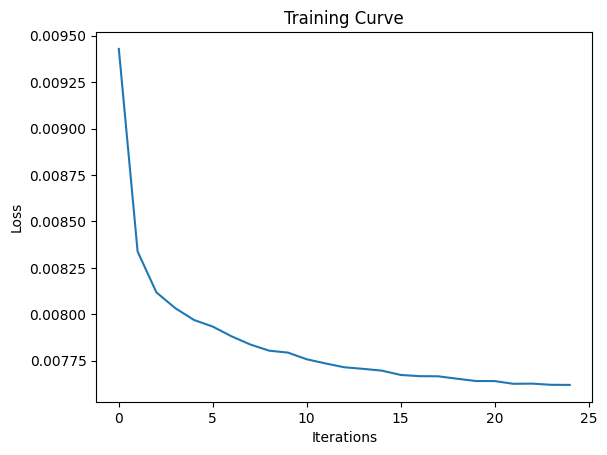

Final Training Accuracy: 0.8124702467789738
Final Validation Accuracy: 0.8147329141040702


In [ ]:
import matplotlib.pyplot as plt

# Accuracy Plot
plt.title("Training Curve")
plt.plot(train_acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.show()

# Loss Plot
plt.title('Training Curve')
plt.plot(losses, label='Training')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

print("Final Training Accuracy: {}".format(train_acc[-1]))
print("Final Validation Accuracy: {}".format(val_acc[-1]))